<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A4-Neural-Network-Classifier" data-toc-modified-id="A4-Neural-Network-Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A4 Neural Network Classifier</a></span><ul class="toc-item"><li><span><a href="#NeuralNetworkClassifier" data-toc-modified-id="NeuralNetworkClassifier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>NeuralNetworkClassifier</code></a></span></li><li><span><a href="#percent_correct" data-toc-modified-id="percent_correct-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>percent_correct</code></a></span></li><li><span><a href="#Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits" data-toc-modified-id="Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Apply <code>NeuralNetworkClassifier</code> to Images of Handwritten Digits</a></span></li><li><span><a href="#Define-train_for_best_validation-and-apply-to-MNIST-data" data-toc-modified-id="Define-train_for_best_validation-and-apply-to-MNIST-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define <code>train_for_best_validation</code> and apply to MNIST data</a></span></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

ANJU GOPINATH

# A4 Neural Network Classifier

## `NeuralNetworkClassifier`

Starting with the `NeuralNetwork` class defined in Lecture Notes 12, complete the subclass `NeuralNetworkClassifier` as discussed.

## `percent_correct`

When trying to classify real data, we need a way to evaluate our performance.  One way is to just calculate the percent of samples correctly classified, and to show a confusion matrix.  Define the function
`percent_correct(Y, T)`, that returns the percent of samples correctly classified, given `T` as a column matrix of class labels, and `Y` as the column matrix of classes predicted by `use`.

In [1]:
import numpy as np
import optimizers as opt
import sys
class NeuralNetwork():

    def __init__(self, n_inputs, n_hiddens_list, n_outputs):

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(n_hiddens_list) + 1

        self.all_weights, self.Ws = self.make_weights()
        self.initialize_weights()
        self.all_gradients, self.Gs = self.make_weights()

        self.stand_params = None
        self.error_trace = []

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'

    def make_weights(self):
        # Create list of matrix shapes, one per layer
        n_in = self.n_inputs
        units = self.n_hiddens_list + [self.n_outputs]
        shapes = []
        for n_units in units:
            shapes.append((n_in + 1, n_units))
            n_in = n_units

        # Allocate contiguous memory to hold all weights
        n_weights = sum([ni * nu for (ni, nu) in shapes])
        all_weights = np.zeros(n_weights)

        # Create numpy views into this memory with the appropriate
        # shapes to be our weight matrices.
        Ws = []
        first = 0
        for (ni, nu) in shapes:
            n_w = ni * nu
            W = all_weights[first:first + n_w].reshape(ni, nu)
            Ws.append(W)
            first += n_w

        return all_weights, Ws

    def initialize_weights(self):
        for W in self.Ws:
            ni, nu = W.shape
            W[:] = np.random.uniform(-1, 1, size=(ni, nu)) / np.sqrt(ni)
        self.error_trace = []

    def forward(self,Xst):
        Ys = [Xst]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1:
                Y = np.tanh(Y)
            Ys.append(Y)
        return Ys[1:]  # remove X from Ys

    def backward(self, Xst, Tst):
        n_samples = Xst.shape[0]

        Ys = self.forward(Xst)
        Ys = [Xst] + Ys  # Ys now has n_layers + 1 elements.  Ws still has n_layers elements.
        delta = - (Tst - Ys[-1]) / (n_samples * self.n_outputs)
        for layeri in range(self.n_layers)[::-1]:
            X = Ys[layeri]
            self.Gs[layeri][:] = self.add_ones(X).T @ delta
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T
                Y = X  # Ys[layeri]
                delta *= 1 - Ys[layeri] ** 2
            # if layeri < self.n_layers - 1:
            #     delta *= 1 - Y ** 2
        # print(self.all_gradients)
        return self.all_gradients

    def mse(self, Xst, Tst):
        Yst = self.forward(Xst)
        return 0.5 * np.mean((Tst - Yst[-1])**2)

    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        Tst = self.standardize_T(T)

        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)
            
        error_trace = optimizer(self.mse, self.backward, [Xst, Tst],
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        self.error_trace += error_trace
        return self

    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def add_ones(self, X):
        return np.insert(X, 0, 1, axis=1)

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = np.mean(Xstds[Xstds > 0])
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

In [2]:
class NeuralNetworkClassifier(NeuralNetwork):
    
    
    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        # Tst = self.standardize_T(T)                                  ## CHANGED

        # NEW PART FROM HERE ...
        
        self.classes, counts = np.unique(T, return_counts=True)
        #print("inside NeuralNetworkClassifier : self.classes :",self.classes,"counts :",counts)
        self.most_common_class = self.classes[np.argmax(counts)]

        if self.n_outputs != len(self.classes):
            raise ValueError(f'''In NeuralNetworkClassifier, the number of outputs must equal
the number of classes in the training data. The given number of outputs
is {self.n_outputs} and number of classes is {len(self.classes)}. Try changing
the number of outputs in the call to NeuralNetworkClassifier().''')

        T_ind_vars = self.make_indicator_variables(T)
        #print("inside train : T_ind_vars is :",T_ind_vars)
        #   ... TO HERE
        
        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(negLL):
            return np.exp(-negLL)                                                    ## CHANGED
            
        error_trace = optimizer(self.neg_log_likelihood, self.backward, [Xst, T_ind_vars],   ## CHANGED
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        
        self.error_trace += error_trace
        return self
    def make_indicator_variables(self, T):
        '''Assumes argument is N x 1, N samples each being integer class label.'''
        # Make sure T is two-dimensional. Should be n_samples x 1.
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)
    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = max(0, np.max(Y))
        expY = np.exp(Y - maxY)
        denom = np.sum(expY, axis=1).reshape((-1, 1)) 
        Y = expY / (denom + sys.float_info.epsilon)             # requires an    import sys
        return Y
    
    def forward(self,Xst):
        Ys = [Xst]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1: 
                #apply tanh only to the hidden layers
                Y = np.tanh(Y)
            if layer_i == self.n_layers-1: 
                #last layer
                Ys.append(self.softmax(Y))
            else: 
                #if not last layer
                Ys.append(Y)
        return Ys[1:]  # remove X from Ys
   
    def backward(self, Xst, Tst):
        n_samples = Xst.shape[0]

        Ys = self.forward(Xst)
        Ys = [Xst] + Ys  # Ys now has n_layers + 1 elements.  Ws still has n_layers elements.
        delta = - (Tst - Ys[-1]) / (n_samples * self.n_outputs)
        for layeri in range(self.n_layers)[::-1]:
            X = Ys[layeri]
            self.Gs[layeri][:] = self.add_ones(X).T @ delta
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T
                Y = X  # Ys[layeri]
                delta *= 1 - Ys[layeri] ** 2
            # if layeri < self.n_layers - 1:
            #     delta *= 1 - Y ** 2
        # print(self.all_gradients)
        return self.all_gradients
    def neg_log_likelihood(self, Xst, T):  # T must be indicator variables
        (N,K) = T.shape
        Y=self.forward(Xst)
        
        LL=0
        
        temp = (np.log(Y[-1]+sys.float_info.epsilon))
        
        result = np.multiply(T,temp)
        result1=np.mean(result)
        
        return -result1
    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        max1=np.argmax(Y,axis=1)
        classes=max1.reshape(-1,1)
        Zs = Ys[:-1]
        return (classes, Y, Zs) if return_hidden_layer_outputs else (classes, Y)

In [3]:
def percent_correct(Y, T):
#given T as a column matrix of class labels, and Y as the column matrix of classes predicted by use
    number_of_correct = 0
    for i, j in zip(range(len(Y)), range(len(T))):
        if Y[i]==T[j]:
            number_of_correct=number_of_correct+1
    percent=(number_of_correct/len(Y))*100
    return percent

A second way to evaluate a classifier is to calculate a confusion matrix. This shows the percent accuracy for each class, and also shows which classes are predicted in error.

Here is a function you can use to show a confusion matrix.

In [4]:
import pandas

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

## Apply `NeuralNetworkClassifier` to Images of Handwritten Digits

Apply your `NeuralNetworkClassifier` to the [MNIST digits dataset](http://deeplearning.net/tutorial/gettingstarted.html).

In [5]:
import pickle
import gzip
import matplotlib.pyplot as plt

In [33]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [7]:
def draw_image(image, label):
    plt.imshow(-image.reshape(28, 28), cmap='gray')
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(label)

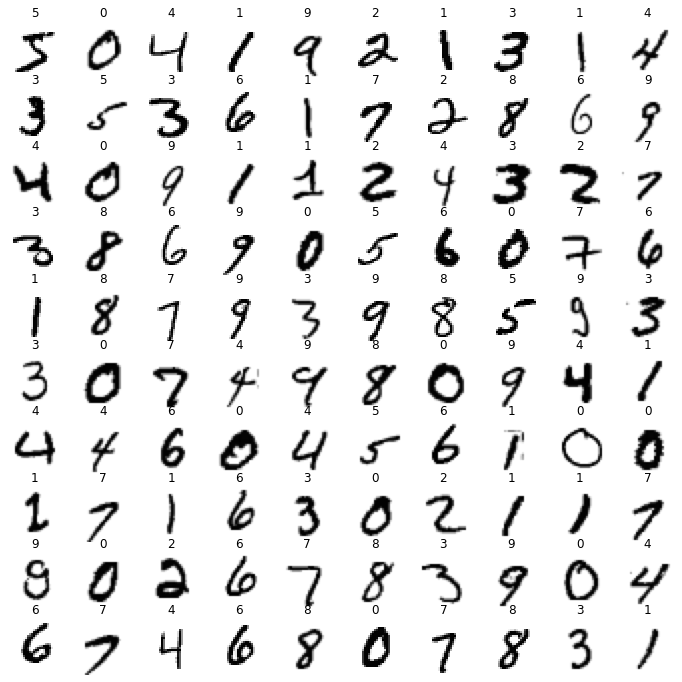

In [8]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    draw_image(Xtrain[i], Ttrain[i,0])

## Define `train_for_best_validation` and apply to MNIST data

Using the function `run` from Lecture Notes 11 as a guide, define a new function `train_for_best_validation` that accepts arguments
* `Xtrain, Ttrain`: matrices of shapes $N\times D$ and $N\times 1$ as input and target training data, where $N$ is number of training samples and $D$ is number of input components,
* `Xval, Tval`: matrices of shapes  $N\times D$ and $N\times 1$ of validation data ($N$ not same value as above)
* `n_epochs`: total number of epochs to train for,
* `n_epochs_per_train`: divide `n_epochs` by this value to get number of times the neural network `train` function is called for this many epochs,
* `n_hiddens_list`: structure of hidden layers,
* `method`: optimizer method,
* `learning_rate`: used for optimizer methods 'adam' and 'sgd'.

It must return 
* `nnet`: resulting neural network with weights that produced the highest accuracy for the validation data set,
* `epoch`: epoch corresponding to best validation accuracy,
* `train_accuracy`: accuracy at that best epoch on training data,
* `val_accuracy`: accuracy at that best epoch on validation data.

This function should call your `percent_correct` function to calculate classification accuracies.

Apply it to the MNIST data as shown below.

In [9]:
def train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, n_epochs, n_epochs_per_train, n_hiddens_list, method,learning_rate=None):
    
    n_reps = n_epochs // n_epochs_per_train
    n_epochs_last_train = n_epochs - n_reps * n_epochs_per_train
    if n_epochs_last_train > 0:
        n_reps += 1
 
    m,n=Xtrain.shape
    #print("Xtrain shape is m:",m," n is ",n)
    #print("unique is :",len(np.unique(Ttrain)))
    num_outputs = len(np.unique(Ttrain))
    nnet = NeuralNetworkClassifier(n, n_hiddens_list, num_outputs)

    accuracies = []
    for reps in range(n_reps):
        n_epoch = n_epochs_per_train 
        if n_epochs_last_train > 0 and reps == n_reps-1:
            n_epoch = n_epochs_last_train
            
        nnet.train(Xtrain, Ttrain, n_epoch, method, verbose=False)
        
        accuracies.append([(reps + 1) * n_epoch,
                      percent_correct(nnet.use(Xtrain)[0], Ttrain),
                      percent_correct(nnet.use(Xval)[0], Tval),nnet])
        
    accuracies = np.array(accuracies)
    best_val_index = np.argmax(accuracies[:, -2])
    best_val_epoch, best_val_train_accuracy, best_val_test_accuracy,nnet = accuracies[best_val_index, :]
    print(f'Best val error is at epoch {best_val_epoch}', end='')
    print(f' with Accuracy for Training data of {best_val_train_accuracy} and Validation data of {best_val_test_accuracy}')

    return nnet,best_val_epoch,best_val_train_accuracy,best_val_test_accuracy

### EXPERIMENT function

This function calls the 'train_for_best_validation' function. It iterates over the list of all parameter variations and calls the 'train_for_best_validation' function. Finally it returns a dataframe table which is displayed.

In [10]:
def experiment(Xtrain, Ttrain,  Xval, Tval,method,n_epochs_list,n_epochs_per_train_list,n_hiddens_listof_list,learning_rate_list):
    import pandas as pd
    
    results_mnist_num=[]
    for learning_rate in range(len(learning_rate_list)):
            for n_hiddens_list in range(len(n_hiddens_listof_list)):
                for n_epochs in range(len(n_epochs_list)):
                    for n_epochs_per_train in range(len(n_epochs_per_train_list)):
                        print("learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train")
                        print(learning_rate_list[learning_rate],n_hiddens_listof_list[n_hiddens_list],n_epochs_list[n_epochs],n_epochs_per_train_list[n_epochs_per_train])
                        
                        nnet, val_epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                              n_epochs_list[n_epochs], n_epochs_per_train_list[n_epochs_per_train], n_hiddens_listof_list[n_hiddens_list], method,learning_rate_list[learning_rate])
                        
                        results_temp=[]
                        results_temp.append(learning_rate_list[learning_rate])
                        results_temp.append(n_hiddens_listof_list[n_hiddens_list])
                        results_temp.append(n_epochs_list[n_epochs])
                        results_temp.append(n_epochs_per_train_list[n_epochs_per_train])
                        results_temp.append(nnet)
                        results_temp.append(train_accuracy)
                        results_temp.append(val_accuracy)
                        results_mnist_num.append(results_temp)
                        #mnist_num_df=[]
                        #for i in [0,1,2,3,5,6]:
                            #mnist_num_df.append(results_temp[i])
                        df_mnist = pd.DataFrame(results_mnist_num, columns=('Learning Rate','Hidden Layers','Epochs','Epochs per Train','nnet','Train Accuracy', 'Val Accuracy'))
    return results_mnist_num,df_mnist

### SGD 

In [11]:

n_epochs_list=[200,250]
n_epochs_per_train_list=[10,50]
n_hiddens_listof_list=[[],[50,50]]
learning_rate_list=[0.05,0.1]


Xtrain1=Xtrain[0:9999,:]
Ttrain1=Ttrain[0:9999,:]
##SGD
print("SGD")
results_mnist_num_sgd,df_mnist_sgd=experiment(Xtrain1, Ttrain1,  Xval, Tval,'sgd',n_epochs_list,n_epochs_per_train_list,n_hiddens_listof_list,learning_rate_list)
print("SGD TABLE :")
print(df_mnist_sgd)
results_array_sgd=np.array(results_mnist_num_sgd)



SGD
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 200 10
Best val error is at epoch 30 with Accuracy for Training data of 96.52965296529653 and Validation data of 91.11
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 200 50
Best val error is at epoch 50 with Accuracy for Training data of 96.95969596959696 and Validation data of 90.71000000000001
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 250 10
Best val error is at epoch 10 with Accuracy for Training data of 94.03940394039404 and Validation data of 91.06
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 250 50
Best val error is at epoch 100 with Accuracy for Training data of 97.21972197219722 and Validation data of 90.68
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [50, 50] 200 10
Best val error is at epoch 40 with Accuracy for Training data of 100.0 and Validation data of 93.82000000000001
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train


### Select the entry with best validation accuracy from the table

In [52]:
results_array_sgd[5,:]


array([0.05, list([50, 50]), 200, 50, NeuralNetwork(784, [50, 50], 10),
       100.0, 93.89999999999999], dtype=object)

In [59]:
best_result_sgd=results_array_sgd[5,:]
print(best_result_sgd)
nnet_1_sgd=results_array_sgd[5,4]
nnet_1_sgd

[0.05 list([50, 50]) 200 50 NeuralNetwork(784, [50, 50], 10) 100.0
 93.89999999999999]


NeuralNetwork(784, [50, 50], 10)

In [54]:
[percent_correct(nnet_1_sgd.use(X)[0], T) for X, T in zip([Xtrain1, Xval, Xtest], [Ttrain1, Tval, Ttest])]

[100.0, 93.71000000000001, 92.96]

### Confusion matrix for best validation accuracy

In [55]:
confusion_matrix(nnet_1_sgd.use(Xval)[0], Tval)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.7,0.1,0.7,0.0,0.3,0.1,0.5,0.2,0.2,0.2
1,0.0,97.9,0.5,0.2,0.1,0.1,0.3,0.2,0.6,0.2
2,0.2,0.3,93.1,1.5,0.9,0.3,0.9,1.4,1.0,0.3
3,0.6,0.2,1.4,91.3,0.1,2.3,0.3,0.5,2.4,1.0
4,0.3,0.6,0.1,0.3,95.4,0.1,0.2,1.0,0.6,1.3
5,0.9,0.1,0.7,3.7,0.9,89.2,2.2,0.2,1.6,0.5
6,0.9,0.1,0.9,0.0,0.2,0.2,97.2,0.2,0.2,0.0
7,0.6,0.6,0.6,1.1,0.6,0.2,0.0,94.8,0.2,1.3
8,0.1,1.2,1.0,2.4,0.3,2.7,0.2,1.0,89.5,1.7
9,0.6,0.2,0.1,0.8,3.0,0.4,0.1,2.7,1.6,90.4


### ADAM

In [14]:
##ADAM
print("ADAM")
results_mnist_num_adam,df_mnist_adam=experiment(Xtrain1, Ttrain1,  Xval, Tval,'adam',n_epochs_list,n_epochs_per_train_list,n_hiddens_listof_list,learning_rate_list)
print("ADAM TABLE :")
print(df_mnist_adam)
results_array_adam=np.array(results_mnist_num_adam)



ADAM
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 200 10
Best val error is at epoch 10 with Accuracy for Training data of 93.96939693969398 and Validation data of 91.14999999999999
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 200 50
Best val error is at epoch 50 with Accuracy for Training data of 95.26952695269527 and Validation data of 91.06
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 250 10
Best val error is at epoch 10 with Accuracy for Training data of 93.92939293929393 and Validation data of 91.19
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 250 50
Best val error is at epoch 50 with Accuracy for Training data of 96.96969696969697 and Validation data of 90.38000000000001
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [50, 50] 200 10
Best val error is at epoch 70 with Accuracy for Training data of 100.0 and Validation data of 93.93
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train


### Select the entry with best validation accuracy from the table

In [56]:
best_result_adam=results_array_adam[4,:]
print(best_result_adam)
nnet_1_adam=results_array_adam[4,4]
nnet_1_adam

[0.05 list([50, 50]) 200 10 NeuralNetwork(784, [50, 50], 10) 100.0 93.93]


NeuralNetwork(784, [50, 50], 10)

In [57]:
[percent_correct(nnet_1_adam.use(X)[0], T) for X, T in zip([Xtrain1, Xval, Xtest], [Ttrain1, Tval, Ttest])]

[100.0, 93.61, 92.89]

### Confusion matrix for best validation accuracy

In [58]:
confusion_matrix(nnet_1_adam.use(Xval)[0], Tval)


Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.1,0.0,0.5,0.6,0.2,0.2,0.5,0.1,0.4,0.4
1,0.0,97.7,0.4,0.2,0.2,0.2,0.3,0.1,0.9,0.1
2,0.4,0.3,92.3,1.5,1.0,0.3,1.1,0.9,1.6,0.5
3,0.4,0.1,2.0,91.5,0.2,2.7,0.2,0.4,1.8,0.7
4,0.1,0.7,0.2,0.1,95.3,0.1,0.3,0.8,0.4,1.9
5,1.0,0.1,0.4,3.7,0.3,88.6,2.1,0.3,2.6,0.8
6,0.5,0.1,0.9,0.0,0.4,0.4,97.0,0.0,0.6,0.0
7,0.6,0.6,0.7,0.9,0.3,0.2,0.0,95.2,0.5,1.1
8,0.1,1.0,0.8,1.8,0.5,3.3,0.4,0.9,90.2,1.1
9,0.4,0.2,0.1,1.0,3.4,0.5,0.1,2.3,1.4,90.5


Call `train_for_best_validation` a number of times to compare accuracies using the three different optimization methods, and a few different values of `n_epochs`, `n_epochs_per_train`, and `n_hiddens_list`, and `learning_rate` when using 'sgd' and 'adam'.  You do not have to find the very best values of these parameters.  For example, for `n_hiddens_list` at least use `[]` (a linear model) and a larger network, like `[100, 100]`.

Show the confusion matrix for the network that gave you the best validation accuracy.

Write at least 10 sentences about what you observe in the accuracy plots, the train, validation and test accuracies, and the confusion matrix.

### Observations

========================

SGD best parameters

========================


Learning Rate: 0.0

Hidden Layers: [50,50] 

Epochs:200 

Epochs per train:50   

Best Training accuracy: 100%

Best Validation accuracy:93.99%  

========================

Adam best parameters

========================


Learning Rate:  0.05    

Hidden Layers: [50,50]

Epochs: 200

Epochs per train: 10

Best Training accuracy: 100%

Best Validation accuracy:93.93%

1. Both SGD and ADAM gave identical accuracies wrt the validation data.(~93%).
The parameters used were also identical. 
Hidden Layers :[50,50], Epochs 200, learning rate 0.05. Only epochs per train varied. SGD required 50 epochs per train and Adam required 10 epochs per train.
2. Both methods gave 100% training accuracy, showing significant overfitting. This is also obvious from the fact that validation accuracy is less.
3. Since SGD took more epochs per train(50), it means that it took less repetitions. Next step would be to compare the time taken with 50 epochs per train and arrive at a conclusion. This should be compared with the time taken by Adam with 10 epochs per train. We could further vary epochs per train with values ranging from 10-50 for both methods and arrive at a conclusion.
4. From the Adam table, it was very interesting to note that whenever the number of hidden layers was empty, validation accuracy fell to around 90%. This shows that with more hidden layers and hidden units, the network learns the features of the input images better. This was also the case on observing the SGD table.
5. From the Adam table, it is interesting to note that within the group with least accuracies, the lowest was obtained by the network with most epochs and most epochs_per_train. So was the case with SGD.
6. At the same time, the highest accuracy for SGD was obtained when epochs_per_train was 50 instead of 10(with the other parameters the same). While also considering the 5th point I made, it becomes obvious that we should do more experiments with epochs_per_train.
7. When hidden layers were [50,50], the ADAM method performed better with 250 epochs and 50 epochs_per_train. 
Similarly, it did better with 250 epochs and 10 epochs_per_train with no hidden layers. Hence , without hidden layers, ADAM method seemed to prefer
fewer epochs_per_train.
No such correlation could be observed for SGD.


# Grading

Download [A4grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.tar), extract `A4grader.py` before running the following cell.

In [17]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Gopinath-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    # Is isinstance(nnet, NeuralNetwork) True?


--- 5/5 points. NeuralNetworkClassifier is correctly of type NeuralNetwork

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5)]

## Testing train #######

Best val error is at epoch 15 with Accuracy for Training data of 98.0 and Validation data of 100.0

--- 5/5 points. Correct best epoch.

--- 5/5 points. Correct train_accuracy.

--- 5/5 points. Correct val_accuracy.

A4 Execution Grade is 55 / 65

__ / 5 points. Correctly downloaded and read the MNIST data.

__ / 10 points. Correctly applied train_for_best_validation function
                to MNIST data.

__ / 5 points. Experimented with different values of parameters as 
               arguments to train_for_best_validation.

__ / 5 points. Show confusion matrix for best neural network.

__ / 10 points. Described results with at least 10 sentences.

A4 Results and Discussion Grade is ___ / 35

A4 FINAL GRADE is  _  / 100

Extra Credit: Earn one point of extra credit for repeating the above
experiments for another classification data set.

A4 EXTRA CREDIT is 0 / 1


# Extra Credit

Repeat the above experiments with a different data set.  Randonly partition your data into training, validaton and test parts if not already provided.  Write in markdown cells descriptions of the data and your results.

### About the dataset: 

I am generating a set of images for each of training, validation and testing datasets. There are 2 classes - squares and diamonds. I am using the code Professor Anderson used in the lecture "
Convolutional Neural Networks Training"

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Image generation function

In [19]:
def make_images(n_each_class):
    '''Make 20x20 black and white images with diamonds or squares for the two classes, as line drawings.'''
    images = np.zeros((n_each_class * 2, 20, 20))  # nSamples, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(n_each_class * 2, 1))
    centers = np.zeros((n_each_class * 2, 2))
    for i in range(n_each_class * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < n_each_class:
            # squares
            images[i, x - r:x + r, y + r] = 1.0
            images[i, x - r:x + r, y - r] = 1.0
            images[i, x - r, y - r:y + r] = 1.0
            images[i, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, range(x - r, x), range(y, y + r)] = 1.0
            images[i, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, range(x, x + r), range(y - r, y)] = 1.0
    T = np.array(['square'] * n_each_class + ['diamond'] * n_each_class).reshape(-1, 1)
    return images, T

### Generate train, validation and test images

In [20]:
n_each_class = 100
Xtrain_ec, Ttrain_ec_0 = make_images(n_each_class)
Xval_ec,Tval_ec_0 = make_images(n_each_class)
Xtest_ec, Ttest_ec_0 = make_images(n_each_class)

Xtrain_ec.shape, Ttrain_ec_0.shape, Xval_ec.shape, Tval_ec_0.shape,Xtest_ec.shape, Ttest_ec_0.shape

((200, 20, 20), (200, 1), (200, 20, 20), (200, 1), (200, 20, 20), (200, 1))

### Create new target arrays

Create new target arrays for train, validation and test data sets. If target==square, the new array will instead have 0 . Similarly, 1 for diamond.

In [21]:
#Training data target

Ttrain_ec=[0]*200

for i in range(len(Ttrain_ec_0)):
    if(Ttrain_ec_0[i]=='square'):
        Ttrain_ec[i]=[0]
    else:
        Ttrain_ec[i]=[1]
Ttrain_ec=np.array(Ttrain_ec)
Ttrain_ec.reshape(200,1)
print(Ttrain_ec.shape)

#Validation data target
Tval_ec=[0]*200

for i in range(len(Tval_ec_0)):
    if(Tval_ec_0[i]=='square'):
        Tval_ec[i]=[0]
    else:
        Tval_ec[i]=[1]
Tval_ec=np.array(Tval_ec)
Tval_ec.reshape(200,1)
print(Tval_ec.shape)

#Test data target
Ttest_ec=[0]*200

for i in range(len(Ttest_ec_0)):
    if(Ttest_ec_0[i]=='square'):
        Ttest_ec[i]=[0]
    else:
        Ttest_ec[i]=[1]
Ttest_ec=np.array(Ttest_ec)
Ttest_ec.reshape(200,1)
print(Ttest_ec.shape)

(200, 1)
(200, 1)
(200, 1)


### Plot a few training images from the 2 classes

In [22]:
def draw_neg_image(image, label=''):
    plt.imshow(-image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

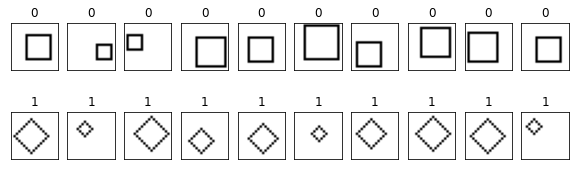

In [23]:
plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    draw_neg_image(Xtrain_ec[i, :], Ttrain_ec[i, 0])

for i in range(10):
    plt.subplot(2, 10, i + 11)
    draw_neg_image(Xtrain_ec[i + n_each_class, :], Ttrain_ec[i + n_each_class, 0])

### Reshape the data sets

In [24]:
Xtrain_ec = Xtrain_ec.reshape(Xtrain_ec.shape[0], -1)
Xval_ec = Xval_ec.reshape(Xval_ec.shape[0], -1)
Xtest_ec = Xtest_ec.reshape(Xtest_ec.shape[0], -1)
Xtrain_ec.shape, Xval_ec.shape,Xtest_ec.shape

((200, 400), (200, 400), (200, 400))

### Train on SGD and print the table with the results

In [25]:
n_epochs_list=[200,250]
n_epochs_per_train_list=[10,50]
n_hiddens_listof_list=[[],[50,50]]
learning_rate_list=[0.05,0.1]

##SGD
print("SGD")
results_mnist_num_sgd_ec,df_mnist_sgd_ec=experiment(Xtrain_ec, Ttrain_ec,  Xval_ec, Tval_ec,'sgd',n_epochs_list,n_epochs_per_train_list,n_hiddens_listof_list,learning_rate_list)
print("SGD TABLE :")
print(df_mnist_sgd_ec)
results_array_sgd_ec=np.array(results_mnist_num_sgd_ec)


SGD
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 200 10
Best val error is at epoch 10 with Accuracy for Training data of 100.0 and Validation data of 89.5
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 200 50
Best val error is at epoch 50 with Accuracy for Training data of 100.0 and Validation data of 90.0
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 250 10
Best val error is at epoch 20 with Accuracy for Training data of 100.0 and Validation data of 90.0
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 250 50
Best val error is at epoch 50 with Accuracy for Training data of 100.0 and Validation data of 90.0
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [50, 50] 200 10
Best val error is at epoch 50 with Accuracy for Training data of 100.0 and Validation data of 90.0
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [50, 50] 200 50
Best val error is at epoch 50 with Accuracy for Training 

In [60]:
best_sgd_ec=results_array_sgd_ec[14,:]
nnet_1_sgd_ec=results_array_sgd_ec[14,4]

### Display the confusion matrix

In [61]:
confusion_matrix(nnet_1_sgd_ec.use(Xval_ec)[0], Tval_ec)

Percent Correct


,0,1
0,89.0,11.0
1,7.0,93.0


### Train on ADAM and print the table with the results

In [27]:
##ADAM
print("ADAM")
results_mnist_num_adam_ec,df_mnist_adam_ec=experiment(Xtrain_ec, Ttrain_ec,  Xval_ec, Tval_ec,'adam',n_epochs_list,n_epochs_per_train_list,n_hiddens_listof_list,learning_rate_list)
print("adam TABLE :")
print(df_mnist_adam_ec)
results_array_adam_ec=np.array(results_mnist_num_adam_ec)


ADAM
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 200 10
Best val error is at epoch 20 with Accuracy for Training data of 100.0 and Validation data of 90.0
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 200 50
Best val error is at epoch 50 with Accuracy for Training data of 100.0 and Validation data of 90.0
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 250 10
Best val error is at epoch 20 with Accuracy for Training data of 100.0 and Validation data of 90.0
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [] 250 50
Best val error is at epoch 50 with Accuracy for Training data of 100.0 and Validation data of 90.0
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [50, 50] 200 10
Best val error is at epoch 20 with Accuracy for Training data of 100.0 and Validation data of 91.5
learning_rate,n_hiddens_list,n_epochs,n_epochs_per_train
0.05 [50, 50] 200 50
Best val error is at epoch 50 with Accuracy for Training

In [62]:
best_adam_ec=results_array_adam_ec[4,:]
nnet_1_adam_ec=results_array_adam_ec[4,4]

### Display the confusion matrix

In [63]:
confusion_matrix(nnet_1_adam_ec.use(Xval_ec)[0], Tval_ec)

Percent Correct


,0,1
0,87.0,13.0
1,7.0,93.0


### Observations

=============================

SGD best performance:

=============================

Best validation accuracy of 91% was obtained in two cases:

Case I:

 Learning Rate : 0.10  
 
 Hidden Layers : [50, 50] 
 
 Epochs : 250          
 
 Epochs per train : 10  
 
 Case II:
 
Learning Rate: 0.05    
 
Hidden Layers: [50,50]

Epochs:200 

Epochs per train:50

=============================

ADAM best performance:

=============================

Best validation accuracy : 91.5%

 Learning Rate: 0.05 
 
 Hidden Layers : [50, 50]   
 
 Epochs : 200          
 
 Epochs per train :10  
 
 I couldn't find much correlation between accuracies and parameters. This might be because of the nature of the data. Within each class, (squares/diamonds), the images shape and border is identical. Only the size and the position varies. This might be the reason.

### Additional code - not for grading

This section contains some additional code I wrote while coding the assignment. I have left it here for future reference.

In [29]:
a=[]
b=[]
b.append(1)
b.append(2)
b.append(3)
b.append(4)
b.append(5)
a.append(b)
print("a is :",a)
print("b is :",b)
c=[]
for i in [0,1,3,4]:
    c.append(a[0][i])
print("c is :",c)

a is : [[1, 2, 3, 4, 5]]
b is : [1, 2, 3, 4, 5]
c is : [1, 2, 4, 5]
